In [90]:
from collections import defaultdict
import zarr
import copick
import numpy as np
import os
from matplotlib import pyplot as plt
import json

In [27]:
# Load the configuration
copickRoot = copick.from_file('../copick_config.json')

In [26]:
# List all available objects
obj_info = [(o.name, o.label) for o in copickRoot.pickable_objects]
print("Pickable objects in this project:")
for name, label in obj_info:
    print(f"  {name}: {label}")

Pickable objects in this project:
  apo-ferritin: 1
  beta-amylase: 2
  beta-galactosidase: 3
  ribosome: 4
  thyroglobulin: 5
  virus-like-particle: 6
  membrane: 8
  background: 9


In [25]:
runs = copickRoot.runs
print("Runs in this project:")
for run in runs:
    print(f"Run: {run.name}")

Runs in this project:
Run: TS_5_4
Run: TS_69_2
Run: TS_6_4
Run: TS_6_6
Run: TS_73_6
Run: TS_86_3
Run: TS_99_9


In [112]:
run = copickRoot.get_run(runs[0].name)

voxel_spacing = run.get_voxel_spacing(10.000)

# Access the specific tomogram
tomogram = voxel_spacing.get_tomogram("denoised")

# Access the Zarr data
zarr_store = tomogram.zarr()
zarr_group = zarr.open(zarr_store)

# Now you can interact with the Zarr data
print(zarr_group.info)

Name        : /
Type        : zarr.hierarchy.Group
Read-only   : False
Store type  : zarr.storage.FSStore
No. members : 3
No. arrays  : 3
No. groups  : 0
Arrays      : 0, 1, 2



In [251]:
# Load the tomogram data
tomogram_vals = zarr_group['0']  # Adjust the key if needed
num_slices = tomogram_vals.shape[0]  # Number of slices in the z-dimension

# Path to the Picks folder
picks_folder = '/Users/jake.brannigan/Documents/Kaggle/CryoET/Data/czii-cryo-et-object-identification/train/overlay/ExperimentRuns/TS_5_4/Picks'

def load_picks(picks_folder, voxel_spacing):
    picks = {}
    for json_file in os.listdir(picks_folder):
        if json_file.endswith('.json'):
            json_path = os.path.join(picks_folder, json_file)
            with open(json_path, 'r') as file:
                pick_data = json.load(file)
            picks[json_file[:-5]] = np.array([
                [point['location']['x'] / voxel_spacing.voxel_size,
                 point['location']['y'] / voxel_spacing.voxel_size,
                 point['location']['z'] / voxel_spacing.voxel_size]
                for point in pick_data['points']
            ])
    return picks

def map_picks_to_slices(picks, num_slices, copick_config):
    """
    Maps particle picks to slices based on their z-coordinates and particle radius.

    Args:
        picks (dict): Dictionary where keys are particle names and values are their 3D locations (numpy arrays).
        num_slices (int): Number of slices to consider along the z-axis.
        copick_config: The copick configuration object containing `pickable_objects`.

    Returns:
        dict: Dictionary mapping slice indices to filtered particle locations.
    """
    # Create a mapping of particle names to their radii from the copick configuration
    particle_radii = {
    obj.name: (obj.radius / 10 if obj.radius is not None else obj.radius)
    for obj in copick_config.pickable_objects
    }

    # Initialize a dictionary for storing particle locations for each slice
    plot_particles = {}
    for slice_idx in range(num_slices):
        plot_particles[slice_idx] = {
            particle: locations[np.abs(locations[:, 2] - slice_idx) < particle_radii[particle]].tolist()
            for particle, locations in picks.items()
        }

    return plot_particles

# Usage
picks = load_picks(picks_folder, voxel_spacing)
plot_particles = map_picks_to_slices(picks, num_slices,copickRoot)

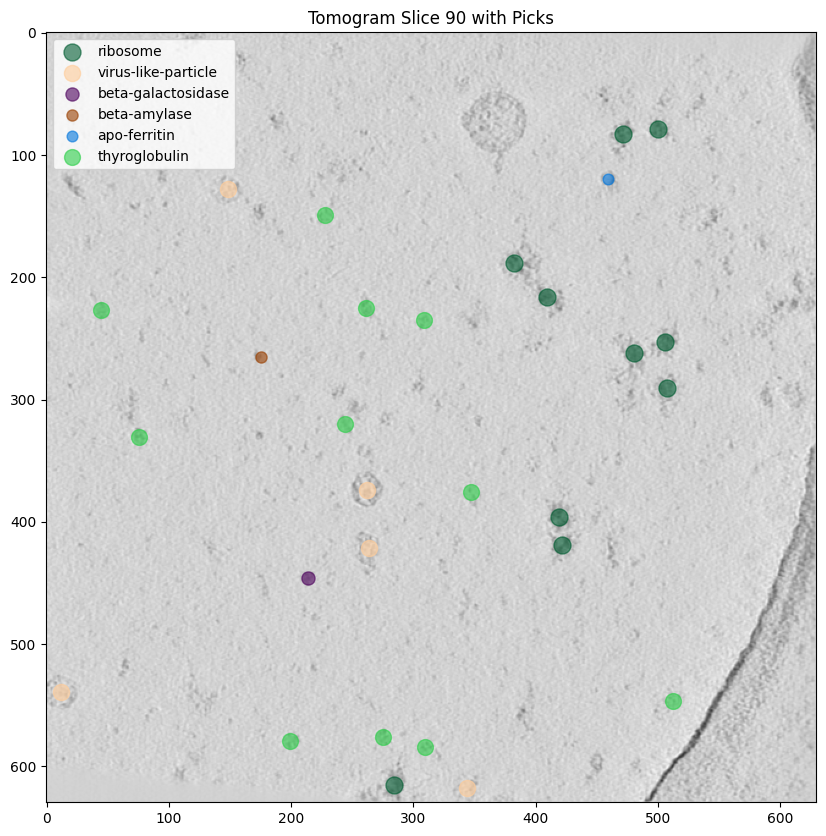

In [255]:
# Visualize picks for a specific slice
slice_idx = 90  # Example slice index
if slice_idx in plot_particles:
    tomogram_slice = tomogram_vals[slice_idx, :, :]
    plt.figure(figsize=(10, 10))
    plt.imshow(tomogram_slice, cmap='gray', alpha=0.8)
    
    for particle, locations in plot_particles[slice_idx].items():
        for i in copickRoot.config.pickable_objects:
            if i.name == particle:
                radius = i.radius
                colour = [cols/255 for cols in i.color[:-1]]
        locations = np.array(locations)
        if len(locations) > 0:
            plt.scatter(locations[:, 0], locations[:, 1], label=particle, s=radius,alpha=0.6,color=colour)
    
    plt.title(f"Tomogram Slice {slice_idx} with Picks")
    plt.legend()
    plt.show()